In [1]:
import pandas as pd

# Abrindo Arquivo de informação
info_df = pd.read_csv('unique_fi_info.csv', encoding='utf-8')

# Convertendo Datas
info_df['dataConstituicao'] =info_df['dataConstituicao'].apply(pd.to_datetime)
info_df['dataCancelamento'] =info_df['dataCancelamento'].apply(pd.to_datetime)

# Informação sobre colunas
print(info_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39437 entries, 0 to 39436
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CNPJ_FUNDO             39437 non-null  object        
 1   nome                   39437 non-null  object        
 2   nomeAbreviado          39428 non-null  object        
 3   dataConstituicao       39436 non-null  datetime64[ns]
 4   dataCancelamento       18916 non-null  datetime64[ns]
 5   situacao               39434 non-null  object        
 6   classe                 38950 non-null  object        
 7   investidorQualificado  39429 non-null  object        
 8   textoTaxaPerformance   23576 non-null  float64       
 9   nomeAdministrador      25318 non-null  object        
 10  nomeGestor             25255 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(8)
memory usage: 3.3+ MB
None


In [2]:
# Sort por ordem de constituição 
info_df.sort_values(by=['dataConstituicao'], inplace=True, ascending=True)
info_df = info_df.reset_index()


In [3]:
from datetime import datetime


def getDuration(then, now):
    """Função para definição da idade do fundo"""     

    duration = now - then 
    duration_in_s = duration.total_seconds() 
    
    def years():
      return divmod(duration_in_s, 31536000) # Seconds in a year=31536000.

    return int(years()[0])




In [4]:
# Usando check for nan ára descobrir fundos abertos, ou com missing data
check_for_nan_canc = info_df['dataCancelamento'].isnull()
check_for_nan_const = info_df['dataConstituicao'].isnull()

In [5]:
# Criando coluna 'idade'
i = 0
for index, row in info_df.iterrows():
    if not check_for_nan_const.at[index]:
        if not check_for_nan_canc.at[index]:
            info_df.at[index, 'idade'] = getDuration(
                                            then=info_df.at[index, 'dataConstituicao'],
                                            now=info_df.at[index, 'dataCancelamento']
                                         )
        else:
            info_df.at[index, 'idade'] = getDuration(
                                    then=info_df.at[index, 'dataConstituicao'],
                                    now=datetime.now()
                                 )

    i+=1

In [6]:
# Preparando dados para análise no Sweetviz
analysis_df = info_df.drop(info_df.columns.difference(['situacao', 'classe', 'investidorQualificado', 'idade', 'nomeAdministrador', 'nomeGestor']), 1)

analysis_df.dropna(subset = ["idade"], inplace=True)

abertos = analysis_df.loc[analysis_df['situacao'] == 'EM FUNCIONAMENTO NORMAL']
cancelados = analysis_df.loc[analysis_df['situacao'] == 'CANCELADA']

In [7]:
# Sorting dataframe 'abertos' por 'idade'
abertos = abertos.sort_values(by=['idade'], ascending=False)

                                             |                                             | [  0%]   00:00 ->…


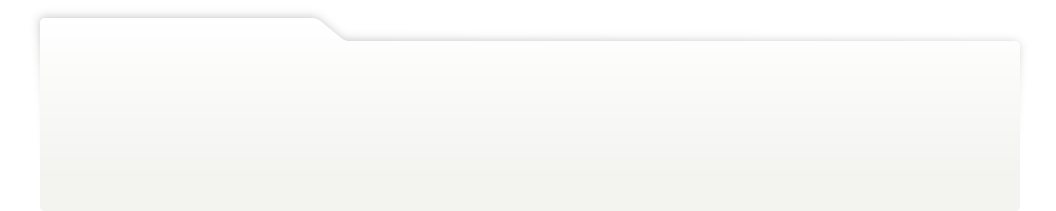
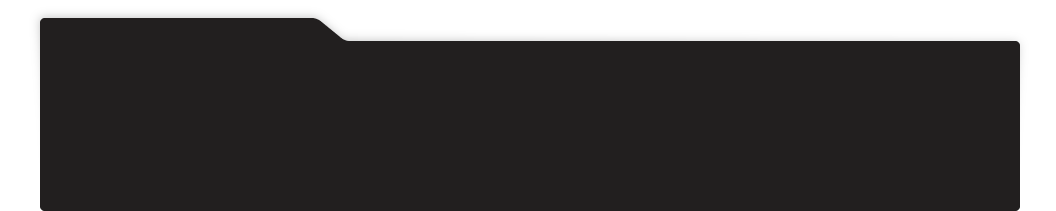
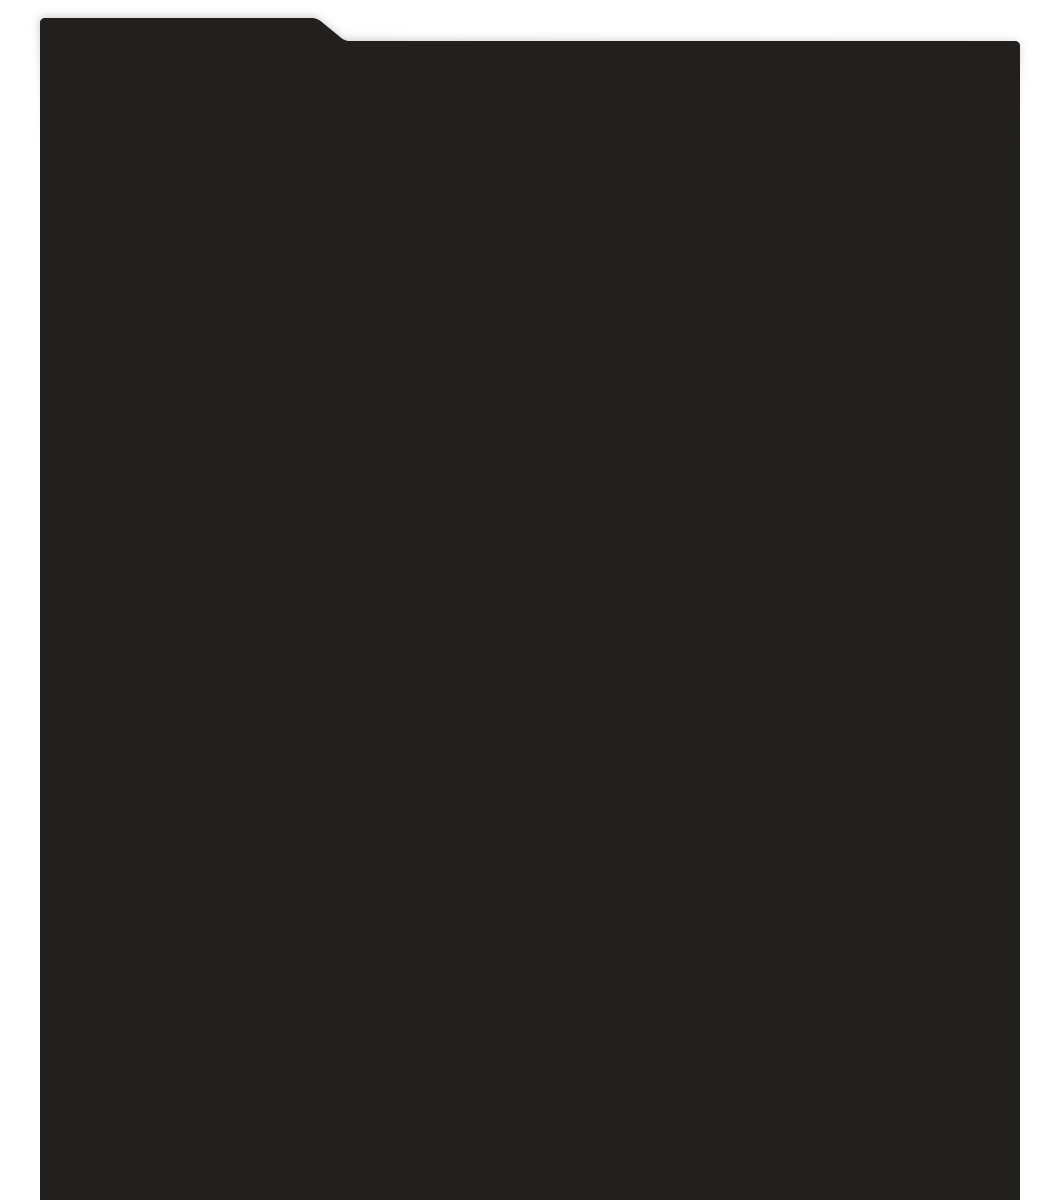
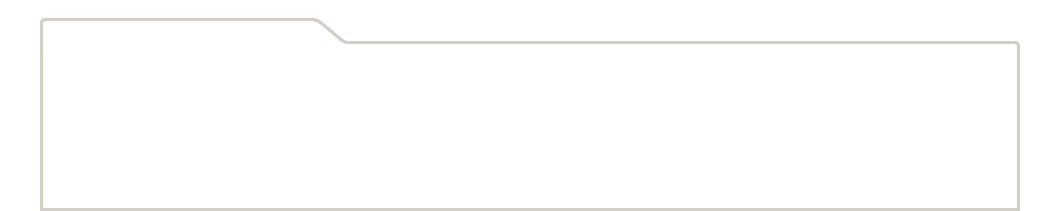
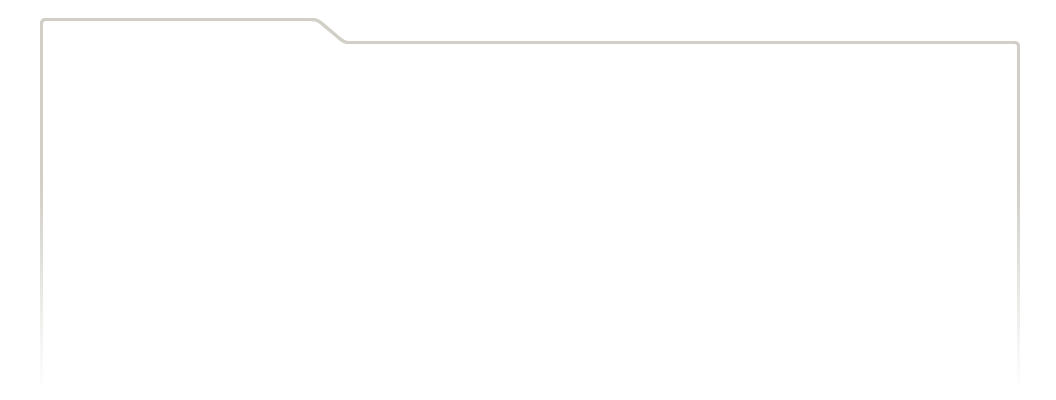
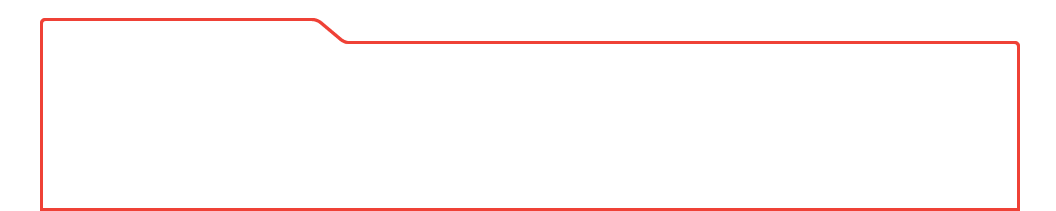
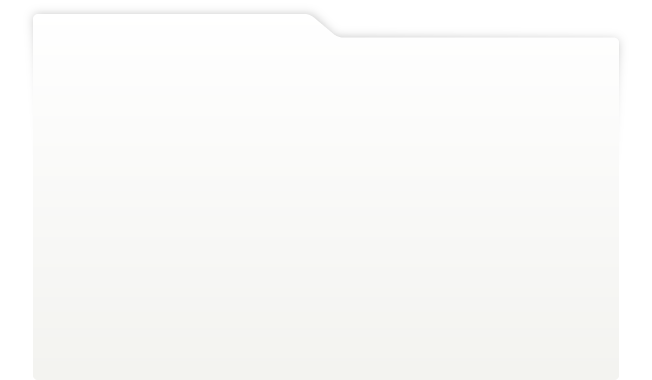
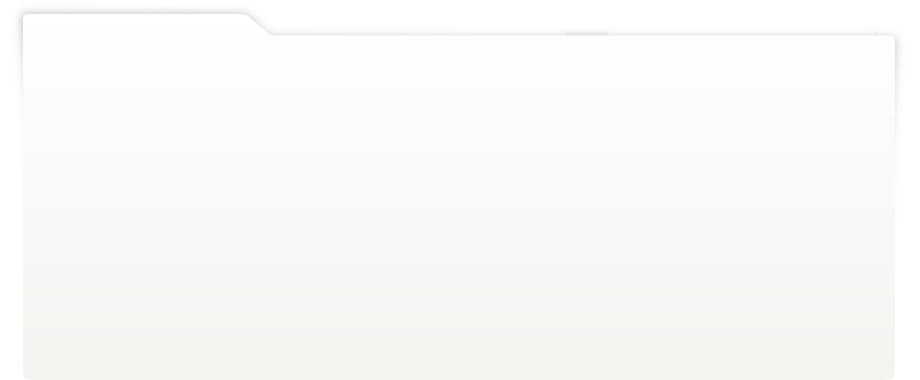
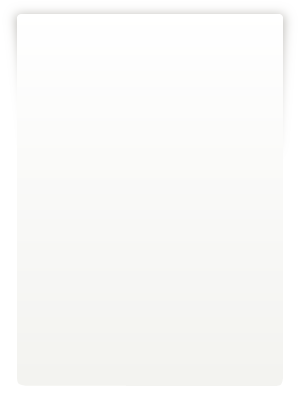
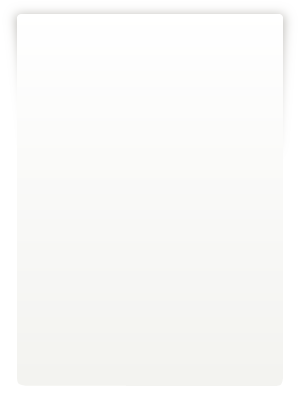
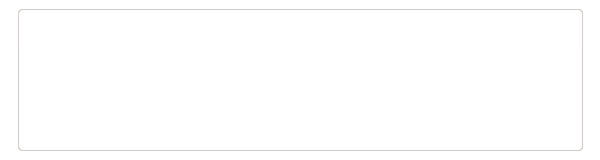
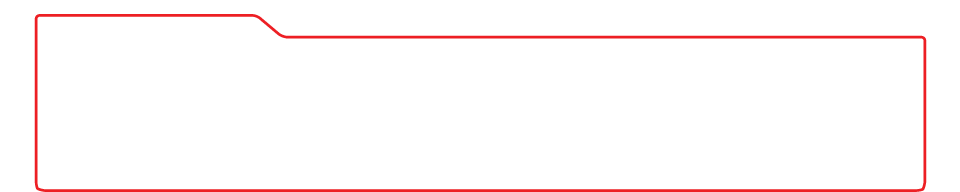
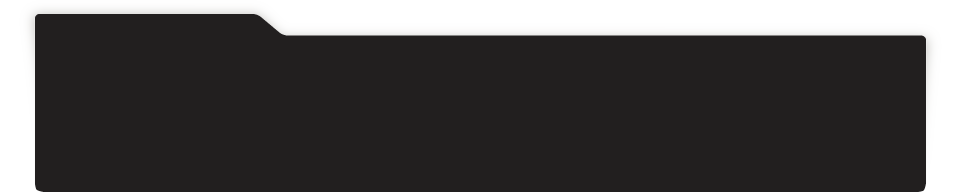
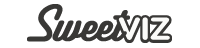
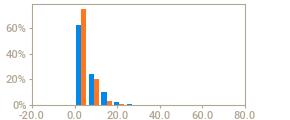
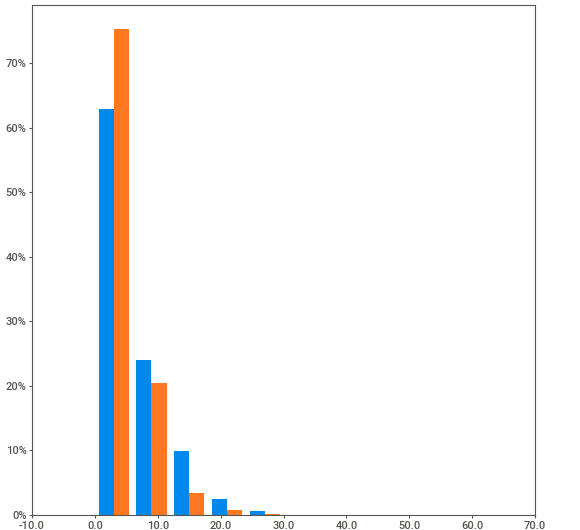
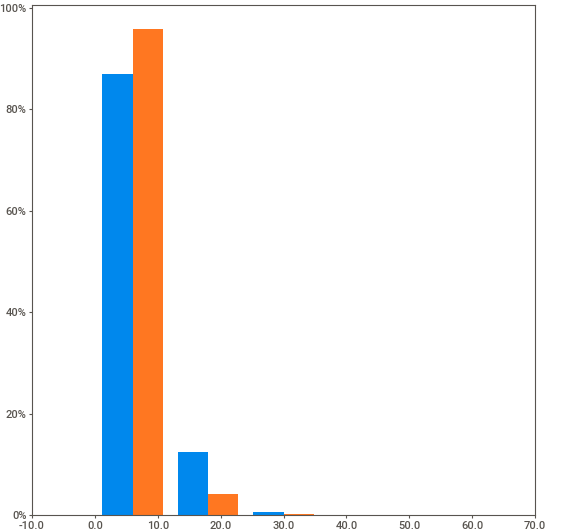
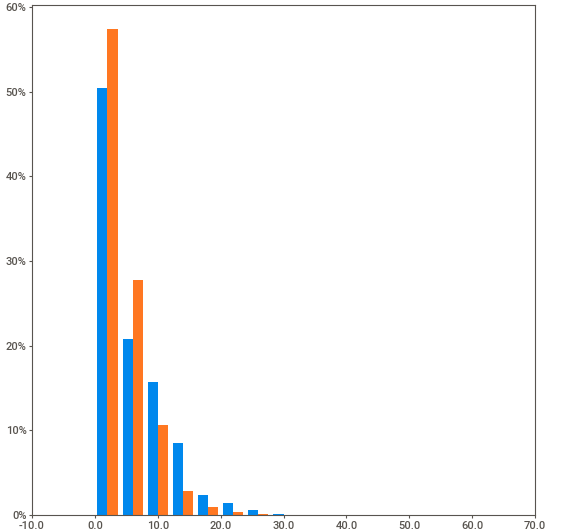
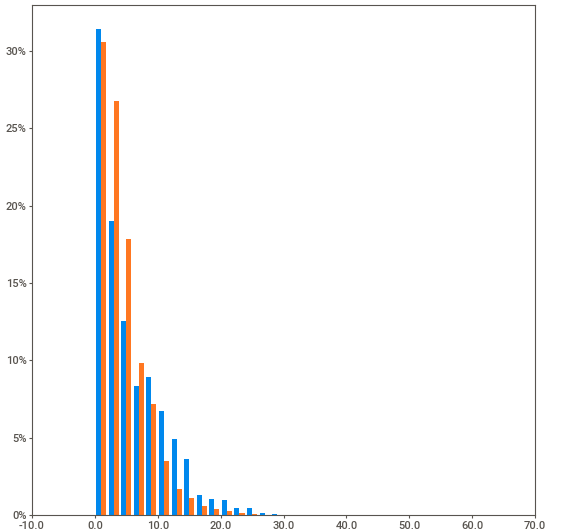
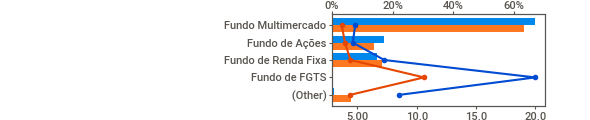
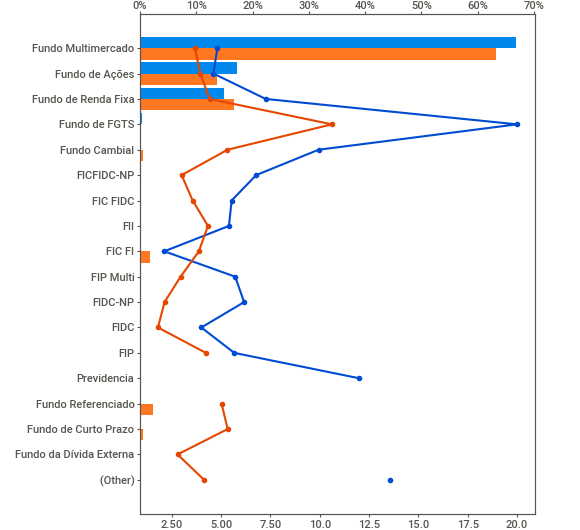
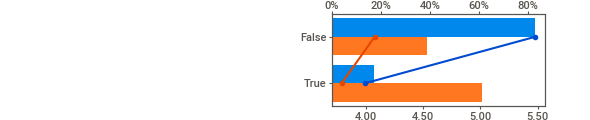
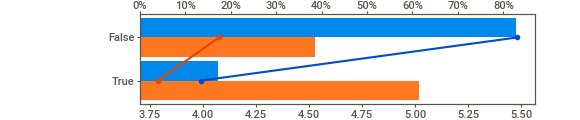
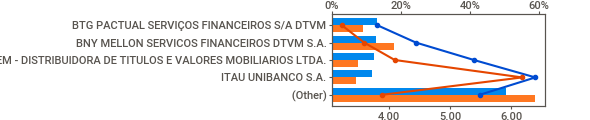
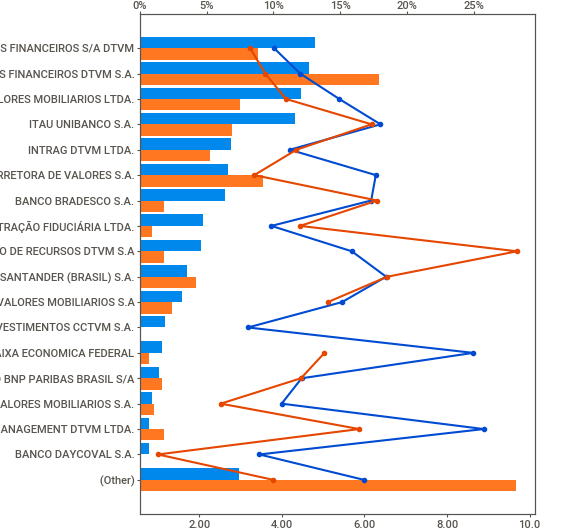
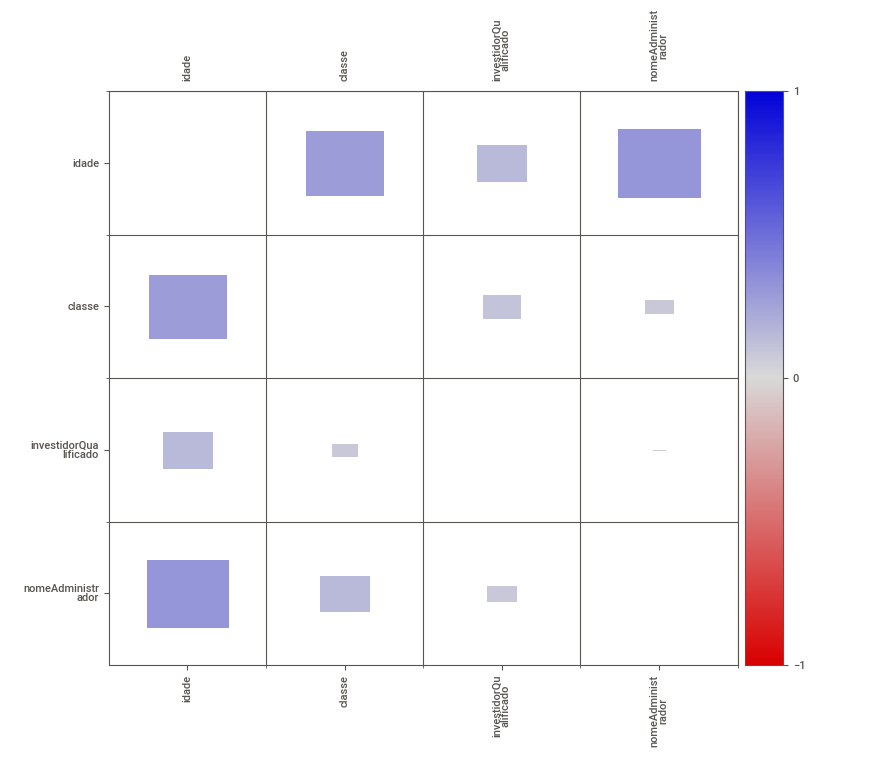
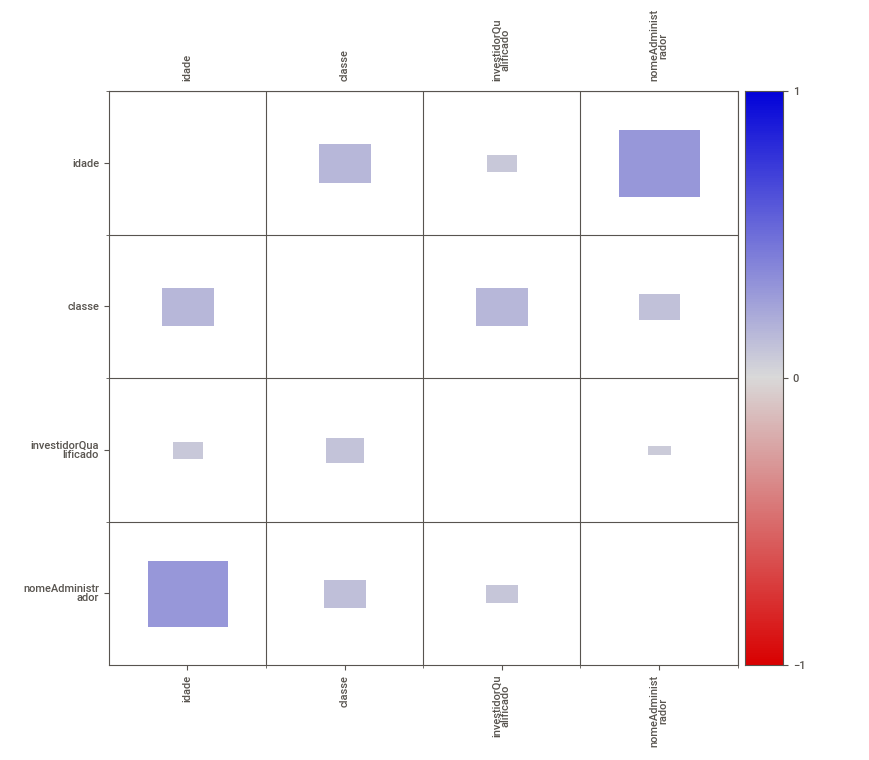

In [8]:
import sweetviz as sv


# Criando report, mas ignorando a coluna situação, pois o report compara justamente as diferentes situações dos fundos
feature_config = sv.FeatureConfig(skip="situacao")

my_report = sv.compare([abertos, 'Abertos'], [cancelados, 'Cancelados'], feat_cfg=feature_config, target_feat='idade')

my_report.show_notebook(scale=0.9)



##### Alguns Insights:

- 75% dos fundos cancelados o foram no seu 5º ano de atividade.

- Dos fundos abertos, 75% tem menos de 8 anos.

- 60% dos fundos, cancelados ou em atividade, são fundos multimercado.

- Mais fundos com investidor qualificado cancelados. (Talvez por que tomam mais riscos e por isso para investidores qualificados, ou então por que a barreira para investidores não qualificados esteja acabando)

- O maior administrador de fundos é o BTG, porém os fundos Itaú tem em média uma duração mais longa em atividade. BNY Mellon possui mais fundos cancelados que ativos em sua história.

- Bradesco e Itaú gestam quase 15% de todos os fundos ativos, mas apenas 8% dos fundos cancelados.

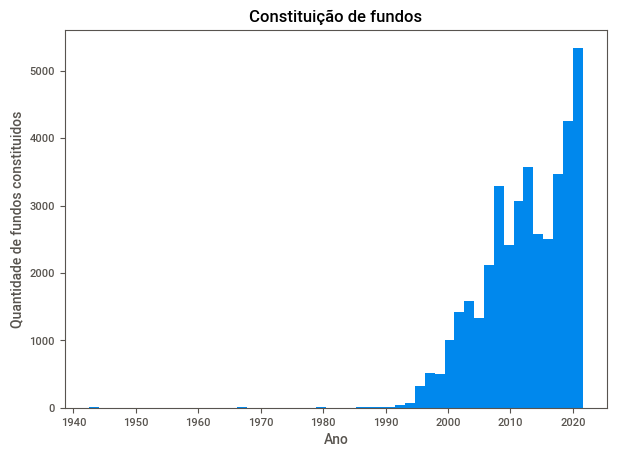

In [9]:
import matplotlib.pyplot as plt

# histograma de criação de fundos por tempo (Não usei o sewwtviz pois ele não suporta timeseries)
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = info_df['dataConstituicao']
plt.hist(x, bins=50)
plt.gca().set(title='Constituição de fundos', ylabel='Quantidade de fundos constituídos', xlabel='Ano');

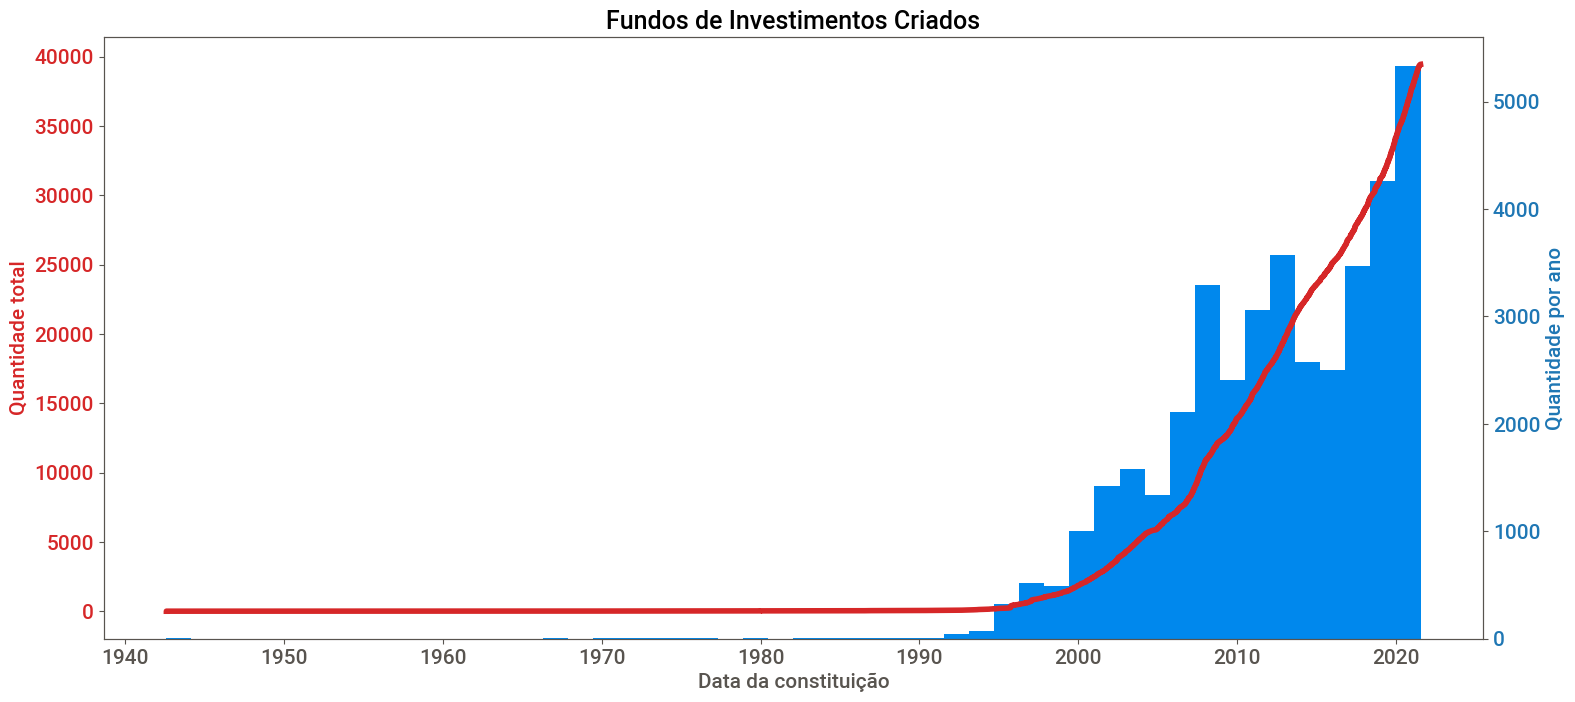

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Plotando Grafico com dois y-axis. Um para o histograma mostrado acima, outro para a quantidade total de fundos criados
# Ps: Faltou o grafico de fundos ativos por ano!!!
t = info_df['dataConstituicao']

data1 = info_df.index

size = 15
plt.rc('ytick', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rcParams.update({'font.size': size})

fig, ax1 = plt.subplots(figsize=(16,7), dpi=100)




color = 'tab:red'
ax1.set_xlabel('Data da constituição')
ax1.set_ylabel("Quantidade total", color=color)

ax1.plot(t, data1, color=color, linewidth=4)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Quantidade por ano', color=color)  # we already handled the x-label with ax1

ax2.hist(t, bins=50)



ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1.set_zorder(1)
ax1.patch.set_visible(False)

plt.title("Fundos de Investimentos Criados")

plt.show()


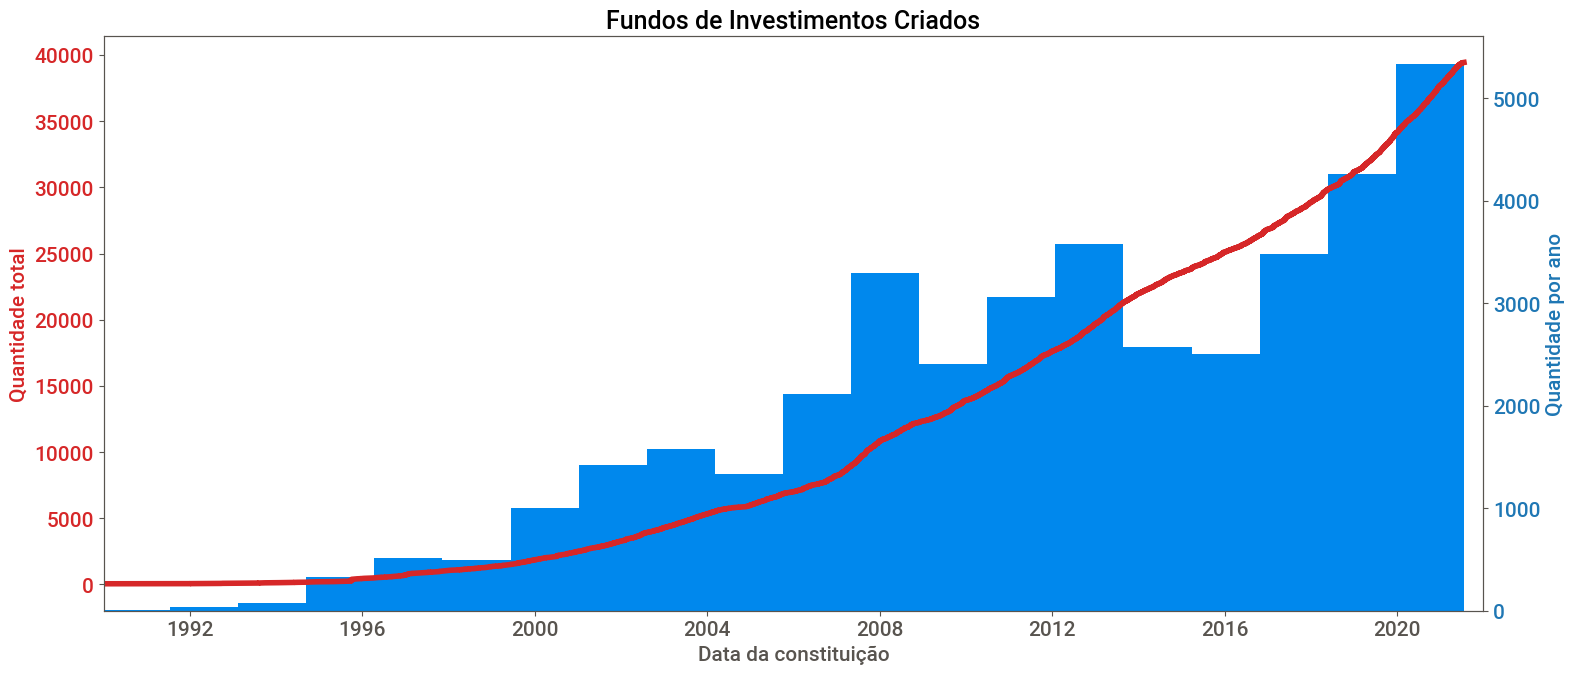

In [15]:
import datetime as dt

# Zoom no Grafico, exibindo dados de 1990 até o presente.
t = info_df['dataConstituicao']

data1 = info_df.index

size = 15
plt.rc('ytick', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rcParams.update({'font.size': size})

fig, ax1 = plt.subplots(figsize=(16,7), dpi=100)




color = 'tab:red'
ax1.set_xlabel('Data da constituição')
ax1.set_ylabel("Quantidade total", color=color)

ax1.plot(t, data1, color=color, linewidth=4)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Quantidade por ano', color=color)  # we already handled the x-label with ax1

ax2.hist(t, bins=50)



ax2.tick_params(axis='y', labelcolor=color)



ax1.set_zorder(1)
ax1.patch.set_visible(False)

plt.title("Fundos de Investimentos Criados")


left = dt.date(1990,1,1)
right = dt.date(2021,12,30)

plt.gca().set_xbound(left, right)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()
